### Imports

In [1]:
import os
import h5py as h5
import json

import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
    
# local imports (found in this repo)
from utils import *
from deconv import *
from animator import SacSacAnimator

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt
%matplotlib notebook

### Release Rates

In [3]:
base_path = "/mnt/Data/NEURONoutput/" + "sac_sac/"

In [4]:
# quanta_h5 = "/mnt/Data/prerna_velocity/2021_06_30/waveforms/quantum_pack.h5"
quanta_h5 = "/mnt/Data/prerna_velocity/2021_05_12_v2/waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]

<IPython.core.display.Javascript object>


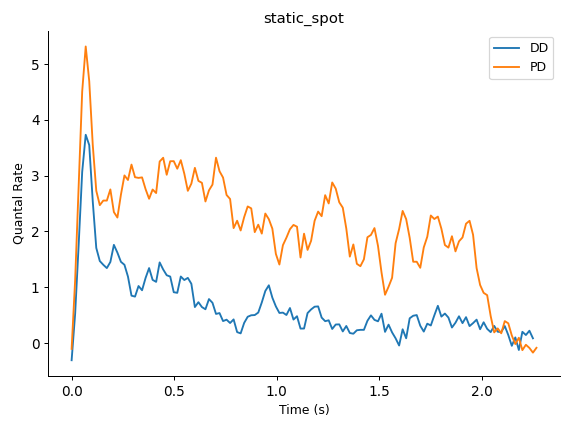

In [5]:
vel = 500
rate_dt = 1 / 58.25

rate_fig, rate_ax = plt.subplots(len(release_rates["DD"][vel]), sharex=True, sharey=True)
rate_ax = [rate_ax] if len(release_rates["DD"][vel]) == 1 else rate_ax
for depth, stims in release_rates.items():
    for ax, (stim, rate) in zip(rate_ax, stims[vel].items()):
        ax.plot(np.arange(len(rate)) * rate_dt, rate, label=depth)

for ax, stim in zip(rate_ax, release_rates["DD"][vel].keys()):
    ax.legend()
    ax.set_title(stim)
    ax.set_ylabel("Quantal Rate")
    clean_axes(ax)

rate_ax[-1].set_xlabel("Time (s)")
rate_fig.tight_layout()
rate_fig.show()

In [6]:
# stim = "snake"
# stim = "moving_spot"
stim = "static_spot"
trans_rate = release_rates["DD"][500][stim] #* 3
sust_rate = release_rates["PD"][500][stim] * 2
sust_rate = sust_rate * np.max(trans_rate) / np.max(sust_rate)

bp_releasers = {
    "sust": train_maker(sust_rate, rate_dt) ,
    "trans": train_maker(trans_rate, rate_dt)
}

<IPython.core.display.Javascript object>


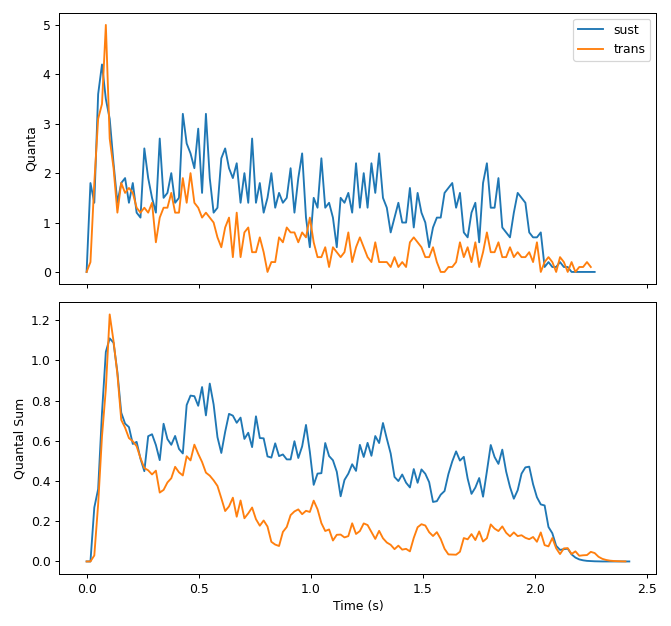

In [7]:
reps = 10
rate_poisson_fig, rate_poisson_ax = plt.subplots(2, sharex=True, figsize=(7.5, 7))

for lbl, rate in {"sust": sust_rate, "trans": trans_rate}.items():
    total_quanta = np.sum([poisson_of_release(rate) for _ in range(reps)], axis=0)
    quantal_sum = sum_quanta(
        total_quanta,
        np.arange(len(total_quanta)) * rate_dt, quantum_pack["quantum"], 
        rate_dt
    ) / reps
    quanta = total_quanta / reps
    
    rpq_sum_xaxis = np.arange(len(quantal_sum)) * rate_dt
    rate_poisson_ax[0].plot(np.arange(len(total_quanta)) * rate_dt, quanta, label=lbl)
    rate_poisson_ax[1].plot(rpq_sum_xaxis, quantal_sum)

rate_poisson_ax[0].set_ylabel("Quanta")
rate_poisson_ax[1].set_ylabel("Quantal Sum")
rate_poisson_ax[1].set_xlabel("Time (s)")
rate_poisson_ax[0].legend()
rate_poisson_fig.tight_layout()
rate_poisson_fig.show()

In [8]:
toy_bps = {
    "bp_props": {
        "sust": {"tau1": 0.1, "tau2": 1., "rev": 0, "weight": .00005, "delay": 0},
        "trans": { "tau1": 0.1, "tau2":  1., "rev": 0, "weight": .00005, "delay": 0},    
    },
    "bp_locs": {"sust": [5], "trans": [i * 5 for i in range(21)]},
}

toy_gaba_props = {
    "loc": 15,  # distance from soma [um]
    "thresh": -50,  # pre-synaptic release threshold
    "tau1": .1,  # inhibitory conductance rise tau [ms]
#     "tau2": 60,  # inhibitory conductance decay tau [ms]
    "tau2": 100,  # inhibitory conductance decay tau [ms]
    "rev": -60,  # inhibitory reversal potential [mV]
    "weight": .001,  # weight of inhibitory NetCons [uS]
#     "delay": .5,
    "delay": 0.,
}

vlasists = {
    "soma_gleak_hh": 1 / 21700,
    "dend_gleak_hh": 1 / 21700,
    "soma_ra": 150,
    "dend_ra": 150,
}


high_ca = {
    "term_cat": 0.003,  # 0.0003,
#     "term_cat": 0.,  # 0.0003,
    "term_cal": 0.,
    "term_can": 0.000, # 0.0003
    "term_cap": 0.000, # 0.0003
    "term_na": 0.0,
    "term_k": 0.0,
    "soma_k": .05,
    "soma_km": 0.0005,
    "dend_k": 0.00,
    "initial_k": 0.01,
#     "term_l": 1,
#     "term_diam": 1,
}


basic_toy_params = {
    **toy_bps,
    **vlasists,
    **high_ca,
    "gaba_props": toy_gaba_props,
}

### Load existing data, or run NEURON model to generate new data
Parameters can be provided to the `SacPair` class in the form of a dict which will be used to overwrite the default properties of the `Sac` objects generated (see `sac_pair.py`).

### Various example `.h5`s:

In [9]:
model_path = base_path + "model_runs/"
save_name = "isolated_test"
load_name = None

if load_name is not None:
    with h5.File(os.path.join(model_path, load_name + ".h5"), "r") as f:
        data = unpack_hdf(f)
else:
    import sac_pair
    model = sac_pair.SacPair(sac_params=basic_toy_params)
    runner = sac_pair.Runner(model, data_path=model_path)
    data = runner.isolated_input_battery(
        [1000.0]
    )
    pack_hdf(model_path + save_name, data)


# data = {0: data} if not bp_dist_mode else data
# first_cond = list(data[0].keys())[0]
# print("params condition: %s" % first_cond)
# model_params = {i: json.loads(d[first_cond]["model_params"]) for i, d in data.items()}
# exp_params = {i: json.loads(d[first_cond]["exp_params"]) for i, d in data.items()}
# exps = {i: {k: v["data"] for k, v in d.items()} for i, d in data.items()}
# avg_exps = {i: apply_to_data(lambda a: np.mean(a, axis=0), e) for i, e in exps.items()}

synapse 0... 0 1 2 3 4 
synapse 1... 0 1 2 3 4 
synapse 2... 0 1 2 3 4 
synapse 3... 0 1 2 3 4 
synapse 4... 0 1 2 3 4 
synapse 5... 0 1 2 3 4 
synapse 6... 0 1 2 3 4 
synapse 7... 0 1 2 3 4 
synapse 8... 0 1 2 3 4 
synapse 9... 0 1 2 3 4 
synapse 10... 0 1 2 3 4 
synapse 11... 0 1 2 3 4 
synapse 12... 0 1 2 3 4 
synapse 13... 0 1 2 3 4 
synapse 14... 0 1 2 3 4 
synapse 15... 0 1 2 3 4 
synapse 16... 0 1 2 3 4 
synapse 17... 0 1 2 3 4 
synapse 18... 0 1 2 3 4 
synapse 19... 0 1 2 3 4 
synapse 20... 0 1 2 3 4 


In [10]:
soma_v = data["data"]["soma"]["a"]["v"]

<IPython.core.display.Javascript object>


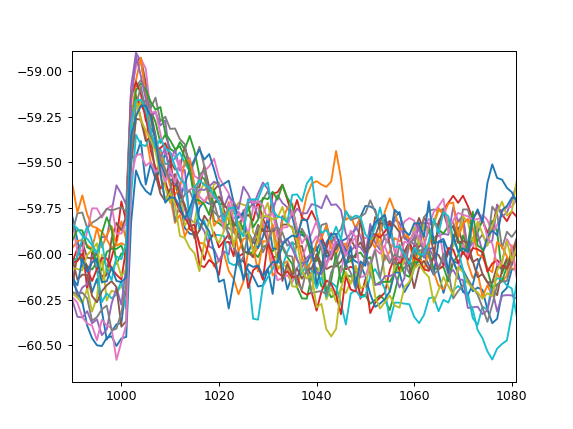

In [11]:
fff, aaa = plt.subplots(1)
for v in np.mean(soma_v, axis=1):
    aaa.plot(v)
    
fff.show()

In [1]:
# json.loads(data[0]["uniform"]["model_params"])

### Common axes, labels, and parameters generated or pulled from the control experiment data which apply to all conditions

In [33]:
dt = exp_params[0]["dt"]
rec_xaxis = np.arange(0, exp_params[0]["tstop"] + dt, dt)
velocities = exp_params[0]["velocities"]

### Experiment dict contents / shapes

In [34]:
print("Electrode recording dict keys:", [k for k in exps[0][first_cond]["soma"]["a"].keys()])
print("Synapse recording dict keys:", [k for k in exps[0][first_cond]["gaba"]["a"].keys()])
print("Recording shape:", exps[0][first_cond]["soma"]["a"]["v"].shape)

Electrode recording dict keys: ['v', 'ica', 'cai']
Synapse recording dict keys: ['i', 'g']
Recording shape: (5, 9, 4001)


<IPython.core.display.Javascript object>


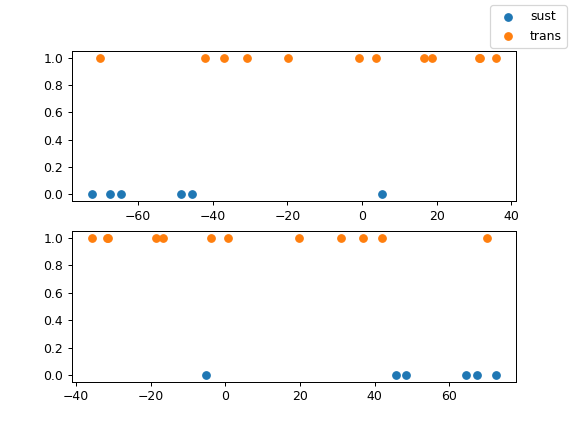

In [35]:
exp_idx = 0
ff, aa = plt.subplots(2)
a_locs = model_params[exp_idx]["a"]["bp_xy_locs"]
b_locs = model_params[exp_idx]["b"]["bp_xy_locs"]
aa[0].scatter(a_locs["sust"]["x"], a_locs["sust"]["y"] , label="sust")
aa[0].scatter(a_locs["trans"]["x"], np.array(a_locs["trans"]["y"]) + 1, label="trans")
aa[1].scatter(b_locs["sust"]["x"], b_locs["sust"]["y"])
aa[1].scatter(b_locs["trans"]["x"], np.array(b_locs["trans"]["y"]) + 1)
ff.legend()

### Model Schematic and Animation
Colours are normalized to the maximum values of their corresponding measures across all velocities and both SACs in a particular condition. Thus, for the matching visible components (e.g. 2nd trans BPCs or terminals), the colour scaling is shared.

- **soma:** membrane voltage at centre
- **terminal:** membrane voltage at tip (GABA pre-synapse)
- **bipolars:** conductance
- **GABA:** conductance

<IPython.core.display.Javascript object>


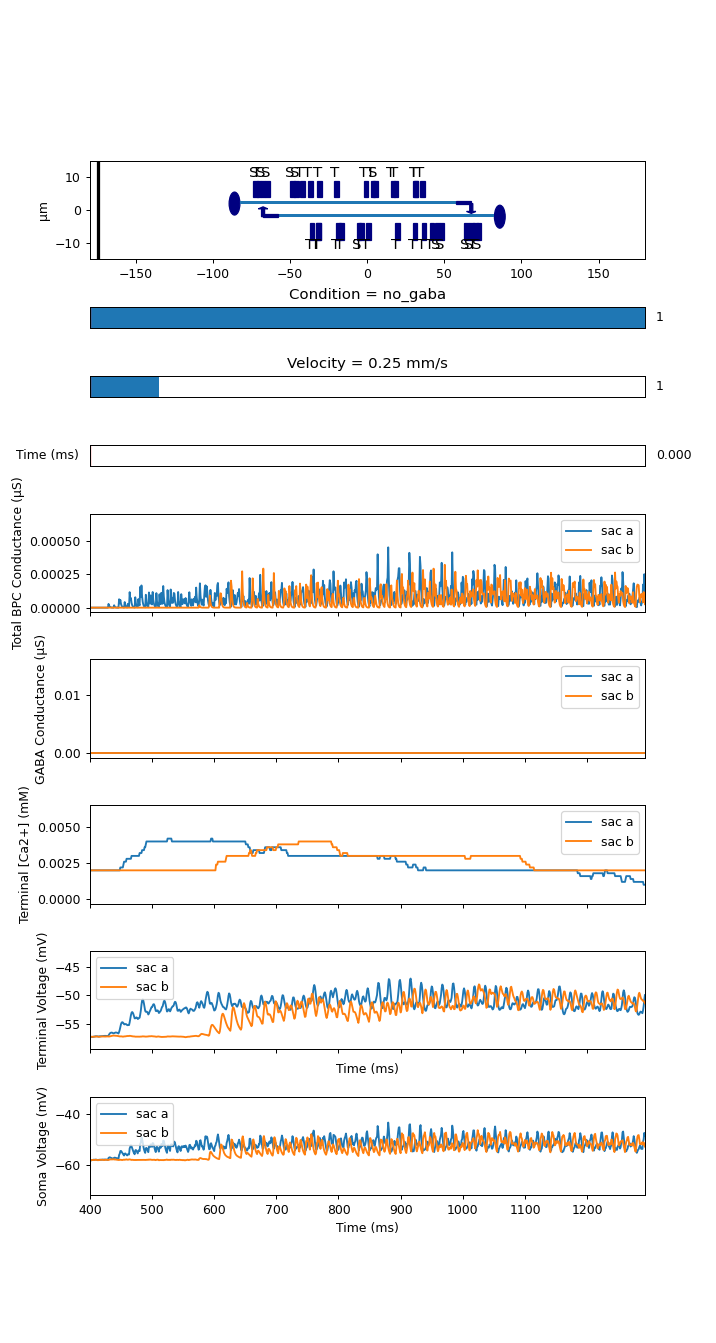

In [36]:
exp_idx = 0
sac_anim = SacSacAnimator(
    exps[exp_idx],
    exp_params[exp_idx],
    model_params[exp_idx], 
    reveal_time=False
)
sac_anim_fig, sac_anim_ax = sac_anim.build_interactive_fig(figsize=(8, 15))

### PN DSi measurements
Here the bar is simply moving in the same direction, over SAC A then SAC B, but we can use the signals in the opposing SACs to calculate a preferred minus null direction selective index.

- **peak:** Using the deflection from the minimum voltage
- **thresh_area:** Area under the voltage above a specified threshold
- **iCa**: Area of calcium current (polarity flipped to positive)
- **gaba:** Area of GABA conductance *applied* the *opposing* SAC  

In [37]:
thresh = -50
dsis = {
    i: { 
        cond: {
            "peak": pn_dsi(
                peak_vm_deflection(exp["term"]["a"]["v"]),
                peak_vm_deflection(exp["term"]["b"]["v"])
            ),
            "thresh_area": pn_dsi(
                thresholded_area(exp["term"]["a"]["v"], thresh),
                thresholded_area(exp["term"]["b"]["v"], thresh)
            ),
            "iCa": pn_dsi(
                np.sum(exp["term"]["a"]["ica"] * -1, axis=-1),
                np.sum(exp["term"]["b"]["ica"] * -1, axis=-1)
            ),
            "gaba": pn_dsi(
                np.sum(exp["gaba"]["b"]["g"], axis=-1), 
                np.sum(exp["gaba"]["a"]["g"], axis=-1)
            ),
            "peak_[Ca]": pn_dsi(
                np.max(exp["term"]["a"]["cai"], axis=-1),
                np.max(exp["term"]["b"]["cai"], axis=-1)
            ),
        }
        for cond, exp in es.items()
    } 
    for i, es in exps.items()
}

avg_dsis = {
    cond: {
        metric: np.mean([dsis[i][cond][metric] for i in dsis.keys()], axis=0)
        for metric in dsis[0][cond].keys()
    }
    for cond in dsis[0].keys()
}

### Velocity Tuning of PN DSi
The above measurements of PN DSi for each of the experimental conditions.
- **control:** sustained-transient bipolar time constants and reciprocal GABA are intact
- **no_gaba:** bipolar mechanism remains, while GABA synapses are removed
- **uniform:** bipolar time constants are all the same (no prox-distal difference)
- **no_mechs:** bipolar time constants are uniform, and GABA synapses are removed

<IPython.core.display.Javascript object>


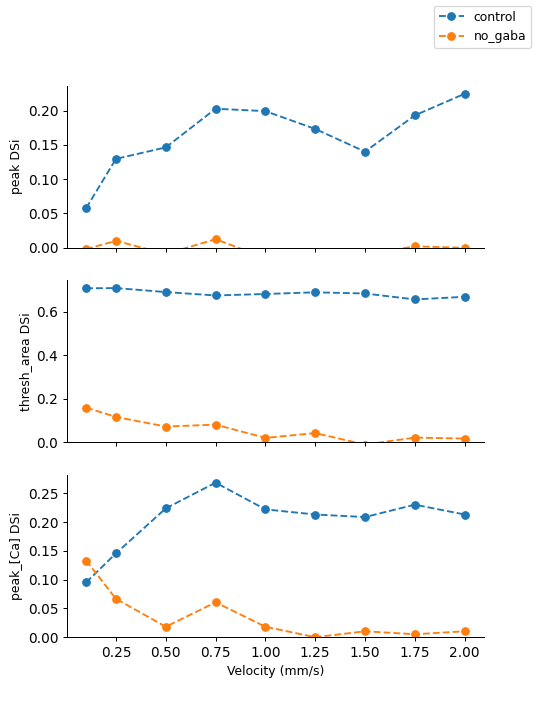

In [38]:
# show_metrics = list(avg_dsis[first_cond].keys())
show_metrics = ["peak", "thresh_area", "peak_[Ca]"]
dsi_fig, dsi_ax = plt.subplots(len(show_metrics), sharex=True, figsize=(6, 8))
for (cond, ds) in avg_dsis.items():
    for i, (a, m) in enumerate(zip(dsi_ax, show_metrics)):
        lbl = {"label": cond} if not i else {}  # only add label once for each condition
        a.plot(velocities, np.mean(ds[m], axis=0), linestyle="--", marker="o", **lbl)

for a, metric in zip(dsi_ax, show_metrics):
    a.set_ylabel("%s DSi" % metric)
    a.set_ylim(0)
    clean_axes(a)

dsi_ax[-1].set_xlabel("Velocity (mm/s)")
dsi_fig.legend()
dsi_fig.show()

### Highlight of the thresholded area metric

<IPython.core.display.Javascript object>


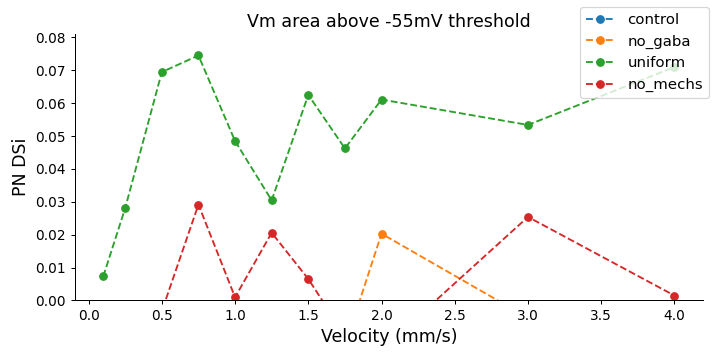

In [78]:
start_vel_idx = 0
end_vel_idx = None
area_dsi_fig, area_dsi_ax = plt.subplots(1, figsize=(8, 4))
for (cond, ds) in avg_dsis.items():
    area_dsi_ax.plot(
        velocities[start_vel_idx:end_vel_idx], 
        np.mean(ds["thresh_area"][:, start_vel_idx:end_vel_idx], axis=0),
        linestyle="--",
        marker="o",
        label=cond
    )

area_dsi_ax.set_title("Vm area above -55mV threshold", fontsize=14)
area_dsi_ax.set_ylabel("PN DSi", fontsize=14)
area_dsi_ax.set_xlabel("Velocity (mm/s)", fontsize=14)
area_dsi_ax.set_ylim(0)
clean_axes(area_dsi_ax)
area_dsi_fig.legend(fontsize=12)
area_dsi_fig.tight_layout()
area_dsi_fig.show()

### Terminal membrane voltage and (proximal) GABA conductance
Trial averages of membrane voltage (recorded at the distal tip) for each membrane, along with the GABA conductance they recieved proximal to their soma from the opposing SAC. Legend indicates the velocity (in mm/s) corresponding to each mean recording presented.

A figure is generated for each of the experimental conditions.

In [ ]:
exp_idx = 0
alpha = .8
rec_figs = {}
for cond, ex in exps[exp_idx].items():
    fig, ax = plt.subplots(3, 2, sharex="col", sharey="row",figsize=(8, 8))
    rec_figs[cond] = {"fig": fig, "ax": ax}
    
    for vel, v_a, v_b, ica_a, ica_b, g_a, g_b in zip(
        velocities,
        np.mean(ex["term"]["a"]["v"], axis=0), 
        np.mean(ex["term"]["b"]["v"], axis=0),
        np.mean(ex["term"]["a"]["ica"], axis=0), 
        np.mean(ex["term"]["b"]["ica"], axis=0),
        np.mean(ex["gaba"]["a"]["g"], axis=0),
        np.mean(ex["gaba"]["b"]["g"], axis=0)
    ):
        ax[0][0].plot(rec_xaxis, v_a, alpha=alpha)
        ax[0][1].plot(rec_xaxis, v_b, alpha=alpha)
        ax[1][0].plot(rec_xaxis, ica_a, alpha=alpha)
        ax[1][1].plot(rec_xaxis, ica_b, alpha=alpha)
        ax[2][0].plot(rec_xaxis, g_a, alpha=alpha)
        ax[2][1].plot(rec_xaxis, g_b, label="%.2f mm/s" % vel, alpha=alpha)

    fig.suptitle(cond)
    ax[0][0].set_title("Sac A")
    ax[0][1].set_title("Sac B")
    ax[0][0].set_ylabel("Terminal Voltage (mV)")
    ax[1][0].set_ylabel("Terminal iCa (mA/cm2)")
    ax[2][0].set_ylabel("GABA Conducatance (μS)")
    ax[1][0].set_xlabel("Time (ms)")
    ax[1][1].set_xlabel("Time (ms)")
    fig.legend()
    fig.show()

### Terminal voltages at select velocities and conditions

In [ ]:
exp_idx = 0
# display_conds = ["control", "uniform", "no_gaba"]
display_conds = ["uniform", "no_mechs"]
display_vel_idxs = [2, 6, -1]

vm_fig, vm_ax = plt.subplots(
    len(display_vel_idxs),
    2,
    sharex="col",
    sharey="row",
    figsize=(12, 8)
)

for cond in display_conds:
    for i, row in zip(display_vel_idxs, vm_ax):
        row[0].set_ylabel("Terminal (mV) [ %s mm/s ]" % velocities[i], fontsize=12)
        row[0].set_ylim(-70, -40)
        for ax, (n, sac) in zip(row, exps[exp_idx][cond]["term"].items()):
            ax.plot(rec_xaxis, np.mean(sac["v"][:, i], axis=0), label=cond, alpha=.8)
            clean_axes(ax)

for ax in vm_ax[-1]:
    ax.set_xlim(0, 1000)
    
        
vm_ax[0][0].set_title("Sac A", fontsize=14)
vm_ax[0][1].set_title("Sac B", fontsize=14)
vm_ax[-1][0].set_xlabel("Time (ms)", fontsize=12)
vm_ax[-1][1].set_xlabel("Time (ms)", fontsize=12)
vm_ax[0][0].legend(fontsize=12)
vm_fig.tight_layout()
vm_fig.show()

### Testing terminal calcium accumulation mechanism (display for select conditions at chosen velocities)

In [ ]:
exp_idx = 0
# display_conds = ["control", "uniform", "no_gaba"]
display_conds = ["uniform", "no_mechs"]
display_vel_idxs = [2, 6, -1]

vm_fig, vm_ax = plt.subplots(
    len(display_vel_idxs),
    2,
    sharex="col",
    sharey="row",
    figsize=(12, 8)
)

for cond in display_conds:
    for i, row in zip(display_vel_idxs, vm_ax):
        row[0].set_ylabel("Terminal Ca conc [ %s mm/s ]" % velocities[i], fontsize=12)
#         row[0].set_ylim(-70, -40)
        for ax, (n, sac) in zip(row, exps[exp_idx][cond]["term"].items()):
            ax.plot(rec_xaxis, np.mean(sac["cai"][:, i], axis=0), label=cond, alpha=.8)
            clean_axes(ax)

for ax in vm_ax[-1]:
    ax.set_xlim(0, 1000)
    
        
vm_ax[0][0].set_title("Sac A", fontsize=14)
vm_ax[0][1].set_title("Sac B", fontsize=14)
vm_ax[-1][0].set_xlabel("Time (ms)", fontsize=12)
vm_ax[-1][1].set_xlabel("Time (ms)", fontsize=12)
vm_ax[0][0].legend(fontsize=12)
vm_fig.tight_layout()
vm_fig.show()

### Second animator instance for creating gifs (if desired)

In [ ]:
exp_idx = 0
gif_anim = False
if gif_anim:
    sac_gif_anim = SacSacAnimator(
        exps[exp_idx],
        exp_params[exp_idx], 
        model_params[exp_idx],
        reveal_time=True
    )
    sac_gif_anim_fig, sac_gif_anim_ax1= sac_gif_anim.build_animation_fig(figsize=(8, 12), frameon=False)

In [ ]:
if gif_anim:
    params = [
    #     {"vel_idx": 0, "n_frames": 150, "dt": 20, "gif_step": 60},
    #     {"vel_idx": 1, "n_frames": 150, "dt": 10, "gif_step": 60},
    #     {"vel_idx": 5, "n_frames": 100, "dt": 5, "gif_step": 60},
    #     {"vel_idx": 8, "n_frames": 150, "dt": 2, "gif_step": 60},
    ]

    for ps in params:
        sac_gif_anim.create_vel_gifs(
            os.path.join(base_path, "gifs"),
            ps["n_frames"],
            vel_idx=ps["vel_idx"],
            dt=ps["dt"],
            dpi=100,
            gif_step=ps["gif_step"],
        )

### GABA and Bipolar conductance alignment over velocity

In [ ]:
bp_sums = {i: linear_bp_sum(e) for i, e in avg_exps.items()}
peak_diffs, overlap = {}, {}
for i in avg_exps.keys():
    peak_diffs[i], overlap[i] = {}, {}
    for cond in avg_exps[i].keys():
        peak_diffs[i][cond], overlap[i][cond] = {}, {}
        for sac in ["a", "b"]:
            gaba_peak_i = np.argmax(avg_exps[i][cond]["gaba"][sac]["g"], axis=-1)
            bp_peak_i = np.argmax(bp_sums[i][cond][sac]["g"], axis=-1)
            peak_diffs[i][cond][sac] = (bp_peak_i - gaba_peak_i) * dt
            
            gaba_normed = (
                avg_exps[i][cond]["gaba"][sac]["g"] 
                / (np.sum(avg_exps[i][cond]["gaba"][sac]["g"], axis=-1, keepdims=True) + .00001)
            )
            bp_normed = (
                bp_sums[i][cond][sac]["g"] 
                / (np.sum(bp_sums[i][cond][sac]["g"], axis=-1, keepdims=True) + .00001) 
            )
            overlap[i][cond][sac] = np.sum(gaba_normed * bp_normed, axis=-1)

In [ ]:
dist_avg_diffs = np.mean([v["control"]["b"] for v in peak_diffs.values()], axis=0)
dist_avg_overlap = np.mean([v["control"]["b"] for v in overlap.values()], axis=0)

alignment_fig, alignment_ax = plt.subplots(2, sharex=True)
alignment_ax[0].plot(velocities, dist_avg_diffs)
alignment_ax[1].plot(velocities, dist_avg_overlap)


alignment_ax[0].set_ylabel("Peak Distance (ms)")
alignment_ax[1].set_ylabel("Conductance Area Overlap")
alignment_ax[-1].set_xlabel("Velocity (mm/s)")
alignment_fig.show()